# Seer Technical Interview: EEG Seizure Clasficiation using 1D CNN
This project uses the **BONN EEG Dataset** to train a **1D convolution neural network (CNN)** to distinguish **seizure (ictal) vs non seizure (interictal/healthy) EEG segments**. 
The Bonn dataset contains EEG recordings from healthy volunteers and epilepsy patients, with segments labeled as seizure (ictal) or non-seizure (comprised of interictal and healthy). The goal is to demonstrate a deep learning approach for seizure detection from single-channel EEG data.


### Dataset

**Bonn EEG dataset** contains **five sets (A–E)**, each with 100 single-channel EEG segments (~23.6 seconds each, 4097 samples per segment, 173.61 Hz sampling rate).  

| Set | Description | Seizure? |
|-----|------------|-----------|
| A   | Healthy, eyes open | No |
| B   | Healthy, eyes closed | No |
| C   | Interictal, non-epileptogenic | No |
| D   | Interictal, epileptogenic | No |
| E   | Seizure (ictal) | Yes |


### Challenges of BONN dataset
**Small dataset**: Relatively small dataset, with only 500 segments, 400 which are non-seizure and 100 which are seizure. To address this issue, data augmentation will be used. 

**Class imbalance**: Class imbalance with 4:1 non-seizure to seizure ratio. To address this issue during training, class weights are used. 

**No patient-level data**: BONN dataset has flat datasets containing healthy, interictal and seizure data. Therefore, we do not know which segments came from same patients, therefore training segments may have same patients as validation segments. This may result in over-optimistic performance metrics. Therefore, external validation on another dataset with unseen patient data would be required to get full understanding of dataset. 

### Goals

1. Load and preprocess EEG segments from all sets
2. Normalize and filter EEG signals
3. Build and train a **1D CNN** to classify seizure vs non-seizure segments
4. Evaluate model performance using loss curves, accuracy and confusion matrix
5. Apply data augmentation to address potential overfitting and limited sample size
6. External validation on CHB-MIT data set (if time permits)

### Links:
- [Bonn EEG Dataset](https://www.upf.edu/web/ntsa/downloads/-/asset_publisher/xvT6E4pczrBw/content/2001-indications-of-nonlinear-deterministic-and-finite-dimensional-structures-in-time-series-of-brain-electrical-activity-dependence-on-recording-regi)
- [Original Paper: Andrzejak et al., 2001](https://www.upf.edu/documents/229517819/232450661/Andrzejak-PhysicalReviewE2001.pdf/0e9a54b8-8993-b400-743e-4d64fa29fb63)


In [1]:
## Import and load packages

import os
import numpy as np
import sys
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
import importlib

from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, f1_score, balanced_accuracy_score
from scipy.signal import butter, filtfilt


sys.path.append(os.path.abspath(".."))
import scripts
# import my functions
from scripts.preprocess import normalise_segments
from scripts.utils import plot_eeg_segment
from scripts.preprocess import load_and_preprocess
from scripts.train import train
from scripts.train import evaluate
from scripts.models import simple_EEG_MLP
from scripts.models import simple_EEG_CNN


## Load and Preprocess Data
- **Filtering:** Buttworth filter to remove high frequency noise above 40 Hz

In [2]:
## Load and preprocess data
base_path = os.path.abspath("../data")

# 0:non-seizure, 1: seizure 
folders = {
    "A": 0,
    "B": 0,
    "C": 0,
    "D": 0, 
    "E": 1
}

X, y = load_and_preprocess(base_path, folders)

X = np.array(X) 
print("EEG segments shape:", X.shape)
y = np.array(y)
print("Labels shape:", y.shape)

EEG segments shape: (500, 4097)
Labels shape: (500,)


## Visualise EEG segments

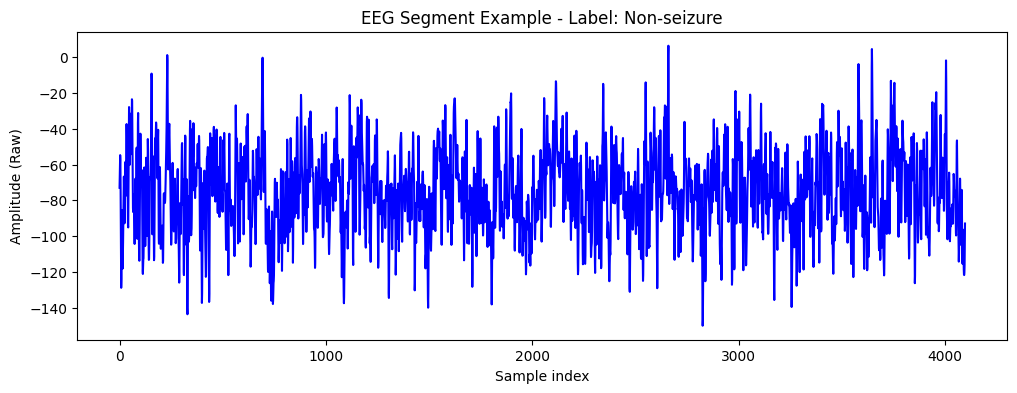

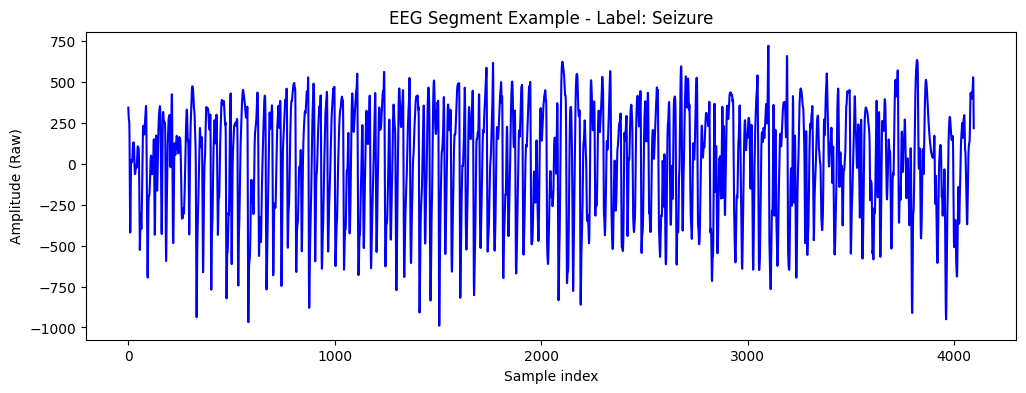

In [ ]:
# Visualise example of non-seizure 
segment = X[0]  
label = y[0]    
plot_eeg_segment(segment, label, num_samples = 4097, norm= False)


# Visualise example of seizure 
segment = X[-1] 
label = y[-1]    
plot_eeg_segment(segment, label, num_samples = 4097, norm= False)

## 1D Convolutional Neural Network

**Overview:**
The 1D convolutional neural network (CNN) is a neural network that applies convolutional filters along the temporal dimension of the EEG signal. For EEG classification, the 1D CNN treats the input as a sequence of time samples which allows the model to learn local temporal patterns that occur across short windows through
- **Convolutional layers:** Extract hierarchical features from raw signals
- **Pooling layers:** Reduce temporal resolution while preserving key features
- **Batch normalization:** Stabilizes training by normalizing layer activations
- **Dropout:** Prevents overfitting by randomly deactivating neurons during training
- **Fully connected layers:** Perform final binary classification (seizure vs. non-seizure) 


**Pros:**
- Automatically learns temporal patterns without manual feature engineering
- Faster and computationally efficient compared to recurrent architectures (e.g. Long Short-Term Memory networks: LSMTs)
- Well suited for time series classification tasks


**Cons:**
- Multiple hyperparameters to tune (e.g. filter sizes, number of channels, pooling strategies)
- Requires sufficient training data to learn robust features 

**Motivation:**
1D CNNs are well-established for EEG seizure detection due to their ability to capture temporal dynamics and patterns characteristic of seizure events while maintaining computational efficiency suitable for real-time applications.


**Model Architecture:**
- Input: 1D time-series EEG signal (4097 samples)
- Architecture: Multi-layer 1D CNN with batch normalization and dropout
- Output: Binary classification (seizure vs non-seizure)
- Regularization: Dropout layers, L2 weight decay, batch normalization
- Loss function: CrossEntropyLoss with class weights to handle imbalance

**Training Strategy:**
- Validation method: 5-fold stratified cross-validation
- Optimizer: Adam with learning rate 1e-3
- Class weighting: Applied to loss function to address 1:4 class imbalance
- Early stopping: Implemented with patience=10 to prevent overfitting
- Normalization: Z-score normalization per fold (using training statistics only)

In [ ]:
## 1D CNN Model

class simple_EEG_CNN(nn.Module):
    def __init__(self, input_length=4097, droupout= 0.5):
        super(simple_EEG_CNN, self).__init__()



        # Conv1: Capture seizure spike patterns (70-200ms)
        # Kernel=25 → ~145ms at 173Hz
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=25, stride=1, padding=12) 
        self.bn1 = nn.BatchNorm1d(16) # BatchNorm after conv1
        self.pool1 = nn.MaxPool1d(kernel_size=4, stride=4)
        self.dropout1 = nn.Dropout(dropout * 0.6)
        # After conv1+pool1: (batch, 16, 1024)

        # Conv2: Capture medium-term patterns (300-500ms)
        # Kernel=15 → ~350ms in the pooled space
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=15, stride=1, padding=7)
        self.bn2 = nn.BatchNorm1d(32) # BatchNorm after conv2
        self.pool2 = nn.MaxPool1d(kernel_size=4, stride=4)
        self.dropout2 = nn.Dropout(dropout * 0.8)  
        # After conv3+pool3: (batch, 32, 256)

        # Conv3: Capture long-term evolution patterns
        self.conv3 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=7, stride=1, padding=3)
        self.bn3 = nn.BatchNorm1d(64) # BatchNorm after conv3
        self.pool3 = nn.MaxPool1d(kernel_size=4, stride=4)
        # after conv 3 (batch, 64, 64)
        
        # Dropout for regularization
        self.dropout3 = nn.Dropout(dropout)

        # global pooling
        self.global_pool = nn.AdaptiveAvgPool1d(1)

        self.fc1 = nn.Linear(64, 64)  
        self.dropout_fc = nn.Dropout(0.5)
        self.fc2 = nn.Linear(64, 2)

    def forward(self, x):
        # Conv block 1
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.pool1(x)
        x = self.dropout1(x)  
        
        # Conv block 2
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.pool2(x)
        x = self.dropout2(x)  
        
        # Conv block 3
        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.pool3(x)
        x = self.dropout3(x)  
        
        # Global pooling and classifier
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout_fc(x)
        x = self.fc2(x)
        
        return x


In [ ]:
# Basic hyperparameter tuning

In [86]:
importlib.reload(scripts.CV)
from scripts.CV import train_with_kfold_cv
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
fold_results = train_with_kfold_cv(
    X, 
    y, 
    simple_EEG_CNN,
    n_splits=5, 
    max_epochs=25, 
    batch_size=32, 
    device=device,
    patience= 5,
    min_delta= 0.001,
    model_kwargs={'input_length': 4097}
)

Starting 5-Fold Cross-Validation

FOLD 1/5
------------------------------------------------------------
  Epoch 10/25 | Train: 0.0801/0.9725 | Val: 0.0597/0.9800 | Patience: 0/5


KeyboardInterrupt: 

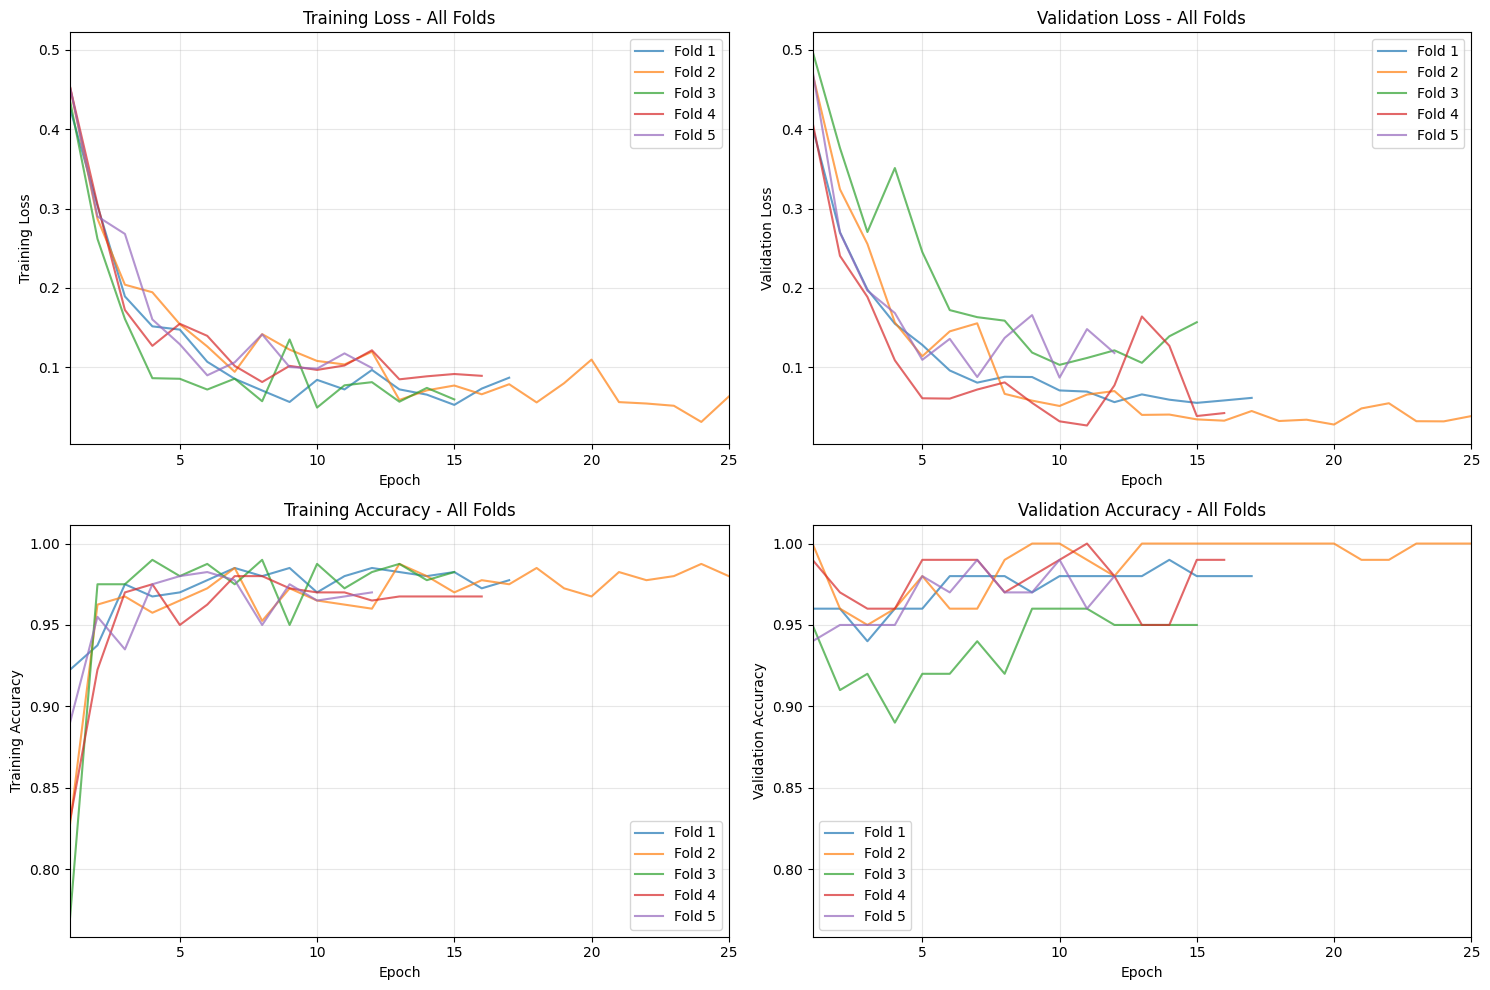

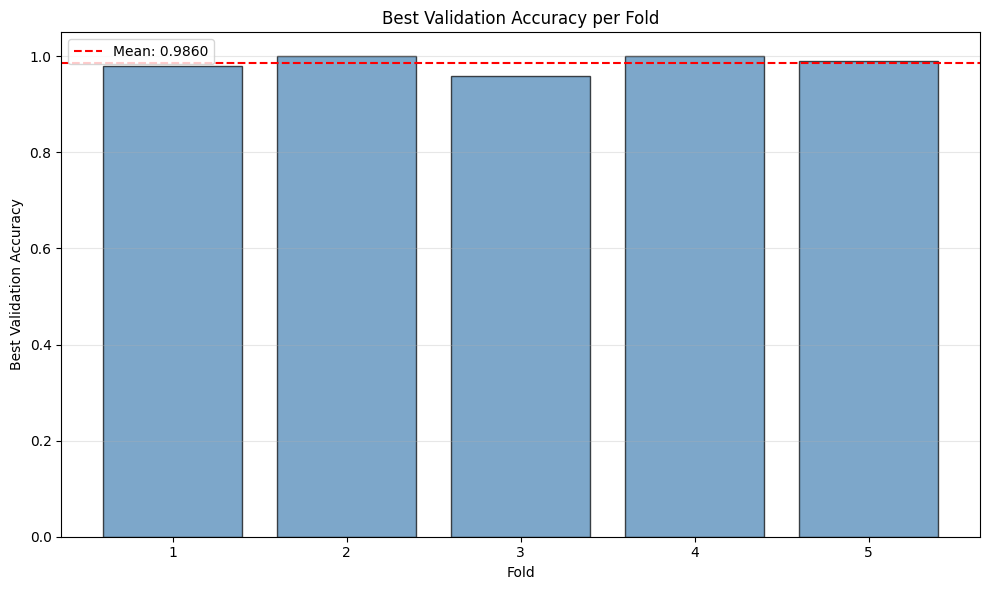

Mean accuracy: 0.9860
Std accuracy: 0.0150
Best fold: 2
Best accuracy: 1.0000


In [ ]:
importlib.reload(scripts.utils)
from scripts.utils import plot_kfold_results
plot_kfold_results(fold_results, 5)

print(f"Mean accuracy: {np.mean(fold_results['best_val_accs']):.4f}")
print(f"Std accuracy: {np.std(fold_results['best_val_accs']):.4f}")

# 6. Get best fold
best_fold_idx = np.argmax(fold_results['best_val_accs'])
print(f"Best fold: {best_fold_idx + 1}")
print(f"Best accuracy: {fold_results['best_val_accs'][best_fold_idx]:.4f}")

Calculating metrics from saved models...

Fold 1: Acc=0.9800 | Bal_Acc=0.9868 | F1=0.9600 | Prec=0.9231 | Rec=1.0000
Fold 2: Acc=1.0000 | Bal_Acc=1.0000 | F1=1.0000 | Prec=1.0000 | Rec=1.0000
Fold 3: Acc=0.9700 | Bal_Acc=0.9352 | F1=0.9091 | Prec=0.9375 | Rec=0.8824
Fold 4: Acc=0.9900 | Bal_Acc=0.9938 | F1=0.9756 | Prec=0.9524 | Rec=1.0000
Fold 5: Acc=0.9800 | Bal_Acc=0.9699 | F1=0.9524 | Prec=0.9524 | Rec=0.9524

KEY METRICS SUMMARY

Metric               Mean ± Std           Range               
------------------------------------------------------------
Accuracy             0.9840 ± 0.0102     [0.9700, 1.0000]
Balanced Accuracy    0.9771 ± 0.0233     [0.9352, 1.0000]
F1 Score             0.9594 ± 0.0300     [0.9091, 1.0000]
Precision            0.9531 ± 0.0259     [0.9231, 1.0000]
Recall (Sensitivity) 0.9669 ± 0.0461     [0.8824, 1.0000]

Average Confusion Matrix:
  TN (Non-Seizure correct): 79.0
  FP (False alarm):         1.0
  FN (Missed seizure):      0.6  ⚠️ Most critical!
  TP

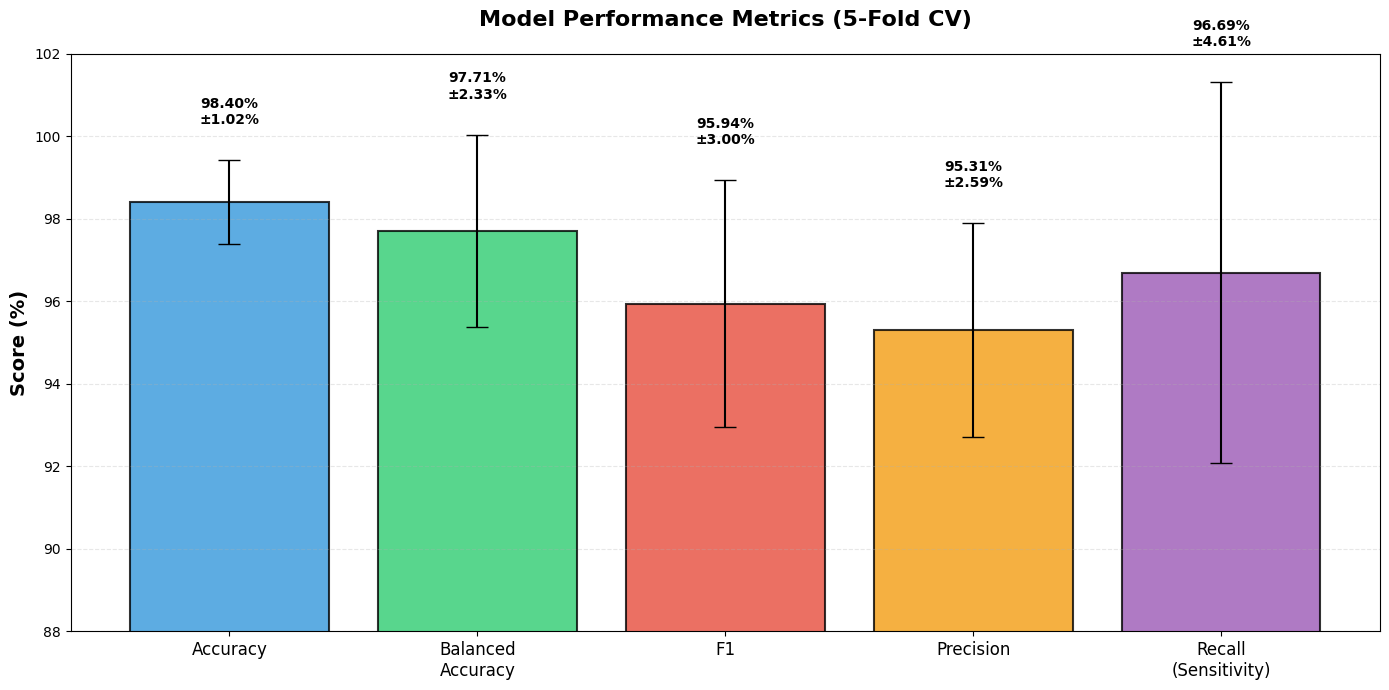

In [100]:
importlib.reload(scripts.CV)
from scripts.CV import calculate_metrics_from_saved_models, print_quick_summary, plot_metrics_comparison        
# Calculate comprehensive metrics
metrics = calculate_metrics_from_saved_models(X, y, simple_EEG_CNN, n_splits=5, device= device)
print_quick_summary(metrics)
plot_metrics_comparison(metrics)

## 1D CNN writeup

- Seeing high performance metrics: may be indicative of overlapping patients and overoptimistic?
- Seeing variability in validation loss and accuracy compared to training: may be indicative of overfitting
- Next steps: add data-augmentation, improve generalisability of model

## Data Augmentation

- What is data augmentation?
- Why is it useful?
- How will I implement

Original seizure samples: 100
Generating 300 augmented samples...
Final augmented seizure count: 400

Balanced dataset:
  Seizures: 400
  Non-seizures: 400


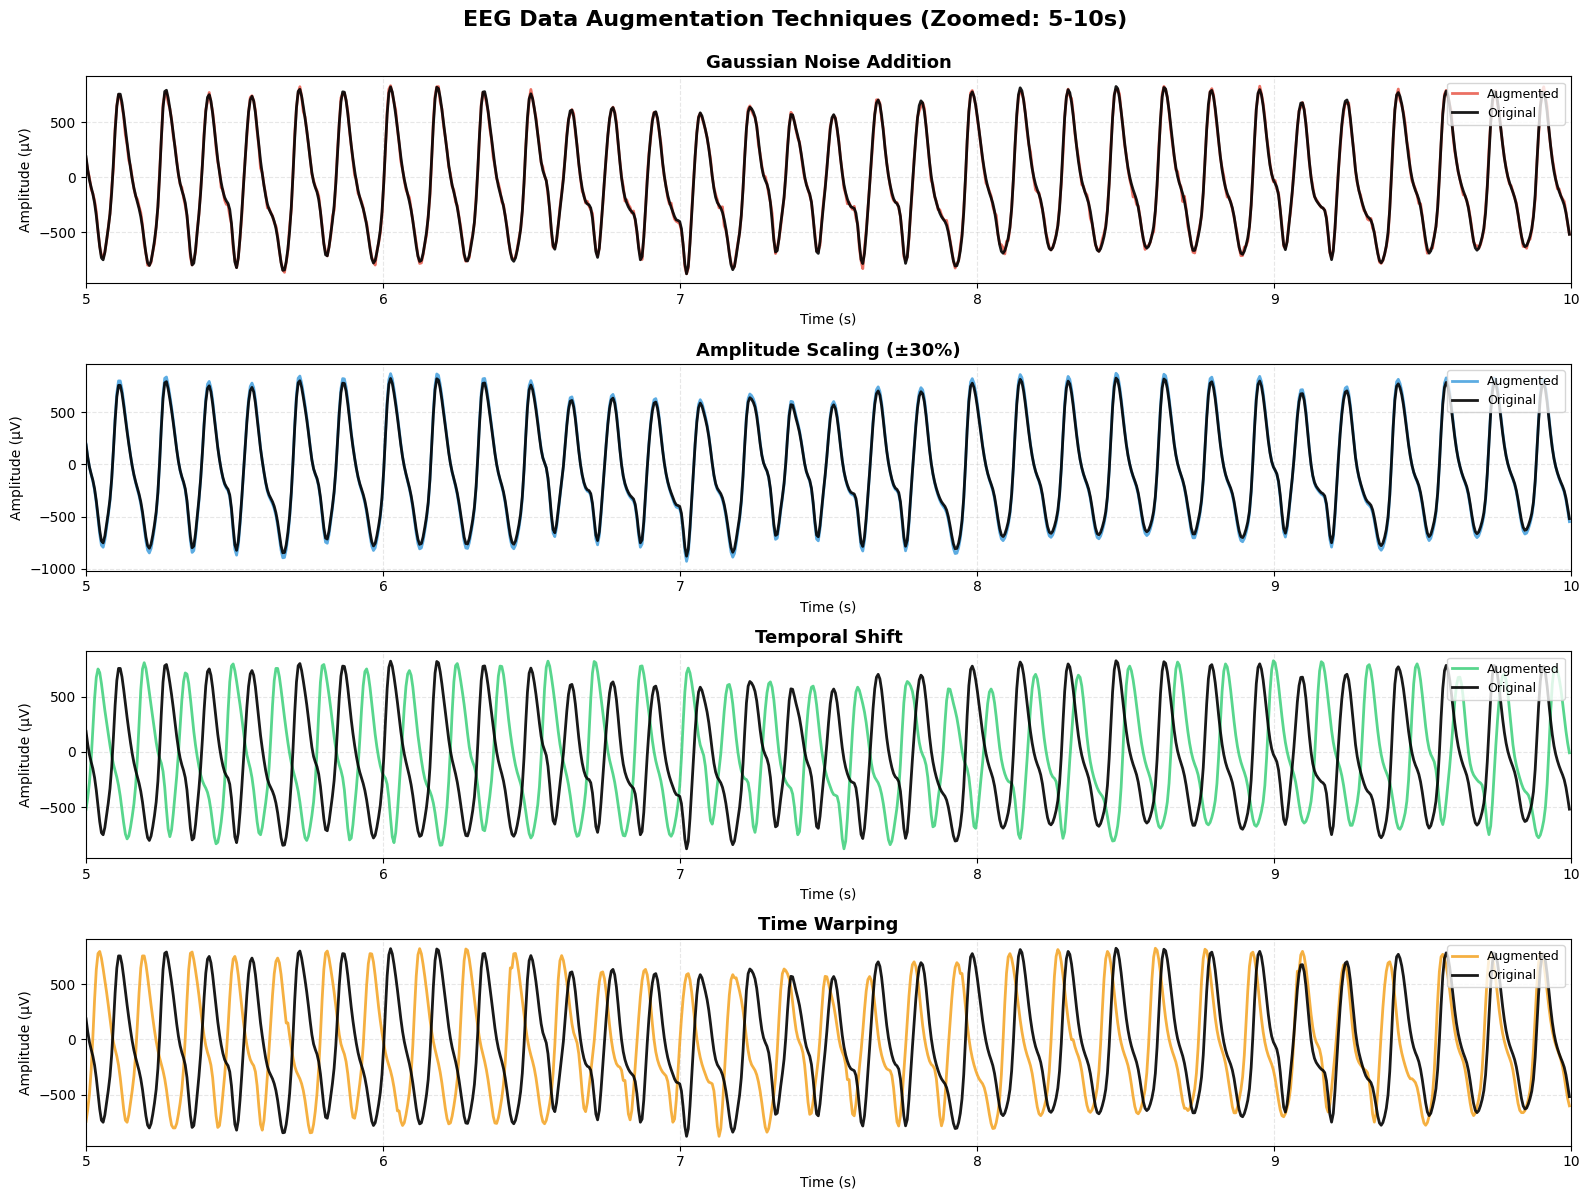

In [75]:
importlib.reload(scripts.augmentation)
from scripts.augmentation import create_augmented_dataset, visualize_augmentation_comparison
# Usage:
# Separate your data
X_seizure = X[y == 1]
X_non_seizure = X[y == 0]
y_seizure = y[y == 1]
y_non_seizure = y[y == 0]

# Augment seizures to match non-seizures (or get closer)
X_seizure_aug, y_seizure_aug = create_augmented_dataset(
    X_seizure, y_seizure, 
    target_count=400,  # Match non-seizure count
    aug_methods=['noise', 'scale', 'shift']
)

# Combine everything
X_balanced = np.vstack([X_seizure_aug, X_non_seizure])
y_balanced = np.hstack([y_seizure_aug, y_non_seizure])

# Shuffle
shuffle_idx = np.random.permutation(len(X_balanced))
X_balanced = X_balanced[shuffle_idx]
y_balanced = y_balanced[shuffle_idx]

print(f"\nBalanced dataset:")
print(f"  Seizures: {(y_balanced == 1).sum()}")
print(f"  Non-seizures: {(y_balanced == 0).sum()}")


visualize_augmentation_comparison(X_seizure, sample_idx=0)

In [107]:
importlib.reload(scripts.augmentation)

from scripts.augmentation import train_with_kfold_cv_augmented
cv_results_with_aug = train_with_kfold_cv_augmented(
    X, y,
    model_class=simple_EEG_CNN,
    n_splits=5,
    max_epochs=50,
    batch_size=32,
    device=device,
    use_augmentation=True,  # Use augmentation
    aug_methods=['noise', 'scale'],
    tune_hyperparams= True, n_tuning_trials = 3
)


Starting 5-Fold Cross-Validation
Using NESTED CV with hyperparameter tuning (3 trials/fold)
Using augmentation: ['noise', 'scale']

FOLD 1/5
------------------------------------------------------------
  Tuning hyperparameters (3 random trials)...


TypeError: simple_EEG_CNN.__init__() got an unexpected keyword argument 'dropout'

In [102]:
# Calculate metrics
metrics_with_aug = calculate_metrics_from_saved_models(
    X, y, simple_EEG_CNN, n_splits=5, device=device
)

Calculating metrics from saved models...

Fold 1: Acc=0.9700 | Bal_Acc=0.9660 | F1=0.9388 | Prec=0.9200 | Rec=0.9583
Fold 2: Acc=1.0000 | Bal_Acc=1.0000 | F1=1.0000 | Prec=1.0000 | Rec=1.0000
Fold 3: Acc=0.9700 | Bal_Acc=0.9585 | F1=0.9143 | Prec=0.8889 | Rec=0.9412
Fold 4: Acc=1.0000 | Bal_Acc=1.0000 | F1=1.0000 | Prec=1.0000 | Rec=1.0000
Fold 5: Acc=0.9900 | Bal_Acc=0.9762 | F1=0.9756 | Prec=1.0000 | Rec=0.9524


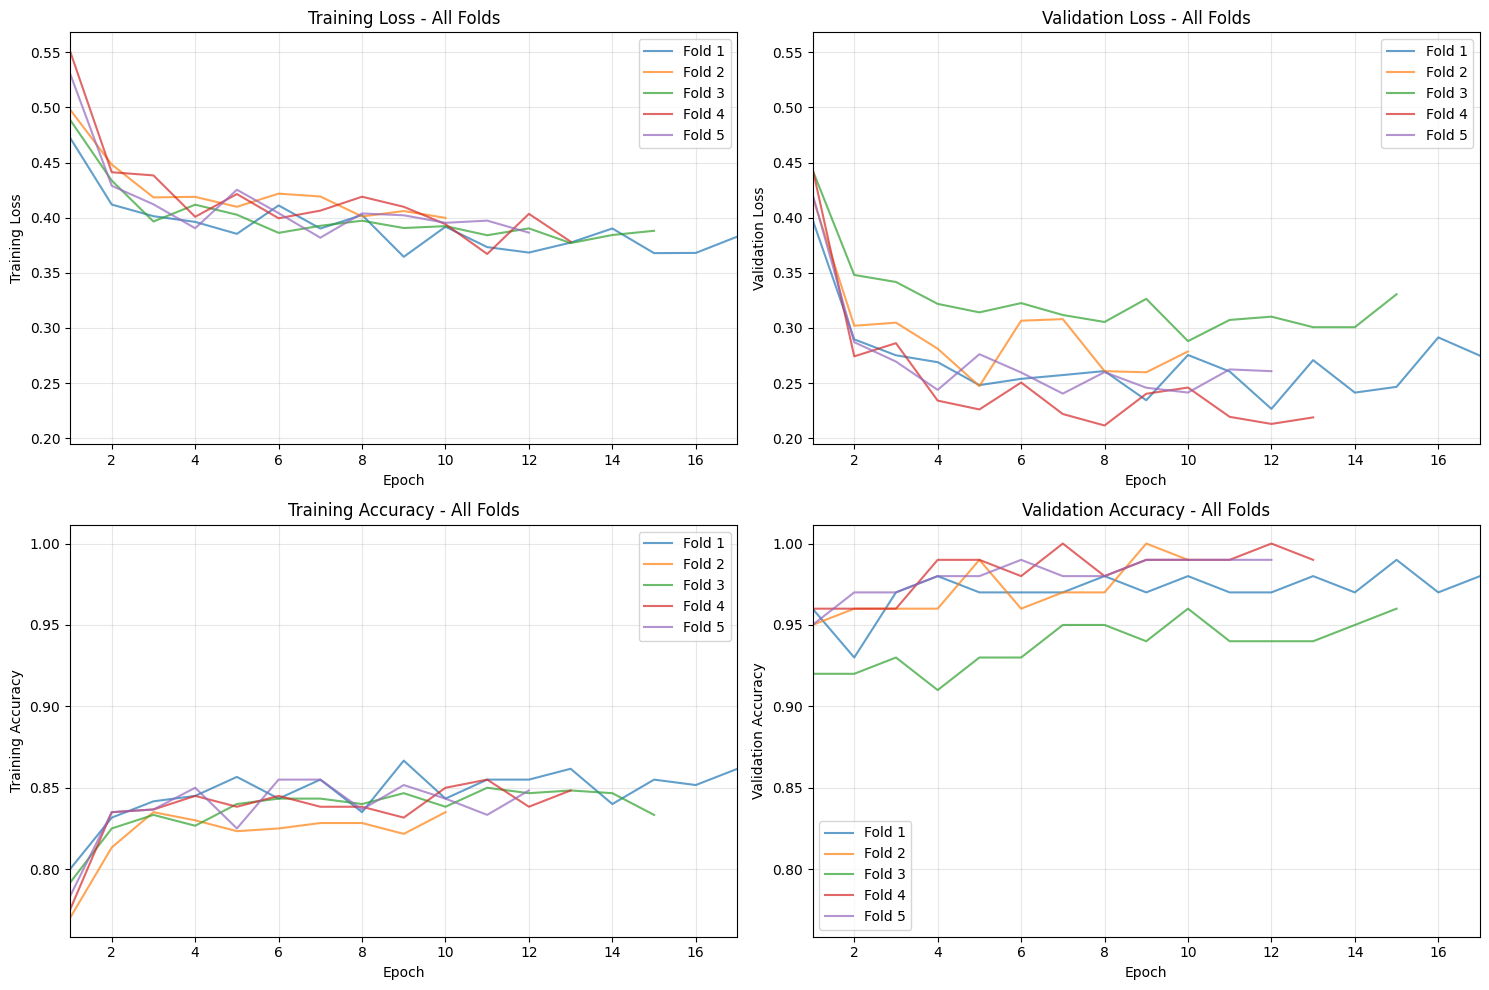

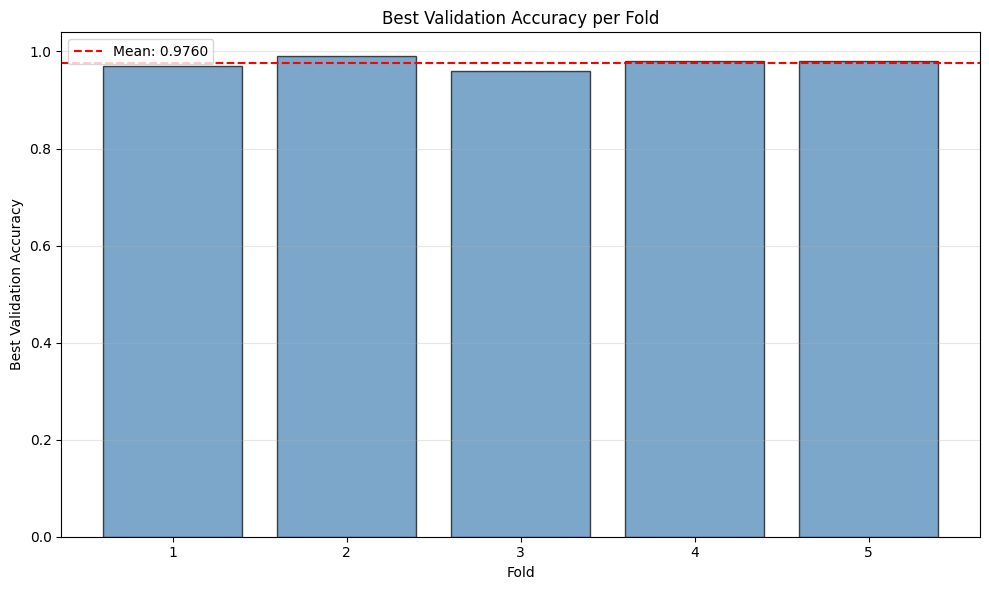

Mean accuracy: 0.9760
Std accuracy: 0.0102
Best fold: 2
Best accuracy: 0.9900


In [103]:
importlib.reload(scripts.utils)
from scripts.utils import plot_kfold_results
plot_kfold_results(cv_results_with_aug , 5)

print(f"Mean accuracy: {np.mean(cv_results_with_aug ['best_val_accs']):.4f}")
print(f"Std accuracy: {np.std(cv_results_with_aug ['best_val_accs']):.4f}")

# 6. Get best fold
best_fold_idx = np.argmax(cv_results_with_aug ['best_val_accs'])
print(f"Best fold: {best_fold_idx + 1}")
print(f"Best accuracy: {cv_results_with_aug ['best_val_accs'][best_fold_idx]:.4f}")

## CHB-MIT EXAMPLES